In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt

In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor


/Users/christoffer/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [145]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')



In [146]:
# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

# Data splits for submissions
X_A = A.drop(columns='pv_measurement')
y_A = A['pv_measurement']
X_B = B.drop(columns='pv_measurement')
y_B = B['pv_measurement']
X_C = C.drop(columns='pv_measurement')
y_C = C['pv_measurement']

# # Data splits for testing
# train_A, test_A = train_test_split(A, test_size=0.2, shuffle=True, random_state=42)
# X_train_A = train_A.drop(columns='pv_measurement')
# y_train_A = train_A['pv_measurement']
# X_test_A = test_A.drop(columns='pv_measurement')
# y_test_A = test_A['pv_measurement']

# train_B, test_B = train_test_split(B, test_size=0.2, shuffle=True, random_state=42)
# X_train_B = train_B.drop(columns='pv_measurement')
# y_train_B = train_B['pv_measurement']
# X_test_B = test_B.drop(columns='pv_measurement')
# y_test_B = test_B['pv_measurement']

# train_C, test_C = train_test_split(C, test_size=0.2, shuffle=True, random_state=42)
# X_train_C = train_C.drop(columns='pv_measurement')
# y_train_C = train_C['pv_measurement']
# X_test_C = test_C.drop(columns='pv_measurement')
# y_test_C = test_C['pv_measurement']


#A plant
train_A, test_A_1 = train_test_split(A, test_size=0.2, shuffle=True, random_state=42)

# Reset the index to ensure uniqueness
train_A = train_A.reset_index(drop=True)
test_A_1 = test_A_1.reset_index(drop=True)

# Separate features and target for testing set
X_test_A = test_A_1.drop(columns='pv_measurement')
y_test_A = test_A_1['pv_measurement']



# B plant
train_B, test_B_1 = train_test_split(B, test_size=0.2, shuffle=True, random_state=42)

# Reset the index to ensure uniqueness
train_B = train_B.reset_index(drop=True)
test_B_1 = test_B_1.reset_index(drop=True)


# Separate features and target for testing set
X_test_B = test_B_1.drop(columns='pv_measurement')
y_test_B = test_B_1['pv_measurement']



# C plant
train_C, test_C_1 = train_test_split(C, test_size=0.2, shuffle=True, random_state=42)

# Reset the index to ensure uniqueness
train_C = train_C.reset_index(drop=True)
test_C_1 = test_C_1.reset_index(drop=True)


# Separate features and target for testing set
X_test_C = test_C_1.drop(columns='pv_measurement')
y_test_C = test_C_1['pv_measurement']

In [69]:
# Optional AutoGluon preprocessing
# train_data = TabularDataset(obs_A)
# test_data = TabularDataset(est_A)



In [147]:
label = 'pv_measurement'

C.info()


<class 'pandas.core.frame.DataFrame'>
Index: 21135 entries, 0 to 2864
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   pv_measurement                           21135 non-null  float64       
 1   date_forecast                            21135 non-null  datetime64[ns]
 2   snow_accumulation                        21135 non-null  float32       
 3   total_radiation                          21135 non-null  float32       
 4   month                                    21135 non-null  int32         
 5   sun_azimuth:d_lag_7                      21135 non-null  float32       
 6   sfc_pressure:hPa_lag_8                   21135 non-null  float32       
 7   t_1000hPa:K_lag_4                        21135 non-null  float32       
 8   dew_or_rime:idx_lag_11                   21135 non-null  float32       
 9   relative_humidity_1000hPa:p_lag_-3       2113

In [148]:
# Fit the predictors
predictor_A = TabularPredictor(label=label, eval_metric='mean_absolute_error').fit(
    train_data=A,  # training data with label
    presets='good_quality',
    hyperparameters={
        'GBM': {'extra_trees': True, 'num_leaves': 31, 'ag_args': {'num_gpus': 1}},
        ##'NN': {'num_epochs': 100, 'dropout': 0.1},
        'CAT': {'iterations': 10000, 'l2_leaf_reg': 3.0},
        'XGB': {'max_depth': 6, 'min_child_weight': 1, 'alpha': 0.1},
    },
    ag_args_ensemble={
        'num_folds': 5,
        'stack_ensemble_levels': 1
    },
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231108_175715"
Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231108_175715"
AutoGluon Version:  0.8.3b20231107
Python Version:     3.11.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:34 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T8103
Disk Space Avail:   28.31 GB / 245.11 GB (11.5%)
Train Data Rows:    34042
Train Data Columns: 51
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 631.39124, 1166.42299)
	If 'regression' is not the correct problem_type, please manually specify the problem_type 

In [149]:
#predictor_B = TabularPredictor(label=label, eval_metric='mean_absolute_error').fit(B, presets='good_quality')
predictor_B = TabularPredictor(label=label, eval_metric='mean_absolute_error').fit(
    train_data=B,  # training data with label
    presets='good_quality',
    hyperparameters={
        'GBM': {'extra_trees': True, 'num_leaves': 31, 'ag_args': {'num_gpus': 1}},
        ##'NN': {'num_epochs': 100, 'dropout': 0.1},
        'CAT': {'iterations': 10000, 'l2_leaf_reg': 3.0},
        'XGB': {'max_depth': 6, 'min_child_weight': 1, 'alpha': 0.1},
    },
    ag_args_ensemble={
        'num_folds': 5,
        'stack_ensemble_levels': 1
    },
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231108_181215"
Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231108_181215"
AutoGluon Version:  0.8.3b20231107
Python Version:     3.11.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:34 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T8103
Disk Space Avail:   27.85 GB / 245.11 GB (11.4%)
Train Data Rows:    25924
Train Data Columns: 51
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 107.07661, 212.51086)
	If 'regression' is not the correct problem_type, please manually specify the problem_type p

In [150]:
#predictor_C = TabularPredictor(label=label, eval_metric='mean_absolute_error').fit(C, presets='good_quality')
predictor_C = TabularPredictor(label=label, eval_metric='mean_absolute_error').fit(
    train_data=C,  # training data with label
    presets='good_quality',
    hyperparameters={
        'GBM': {'extra_trees': True, 'num_leaves': 31, 'ag_args': {'num_gpus': 1}},
        ##'NN': {'num_epochs': 100, 'dropout': 0.1},
        'CAT': {'iterations': 10000, 'l2_leaf_reg': 3.0},
        'XGB': {'max_depth': 6, 'min_child_weight': 1, 'alpha': 0.1},
    },
    ag_args_ensemble={
        'num_folds': 5,
        'stack_ensemble_levels': 1
    },
    use_bag_holdout=True
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231108_182143"
Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231108_182143"
AutoGluon Version:  0.8.3b20231107
Python Version:     3.11.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:41:34 PDT 2023; root:xnu-10002.1.13~1/RELEASE_ARM64_T8103
Disk Space Avail:   27.55 GB / 245.11 GB (11.2%)
Train Data Rows:    21135
Train Data Columns: 51
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 95.84966, 179.44873)
	If 'regression' is not the correct problem_type, please manually specify the problem_typ

# Predicting

In [ ]:
predictor_A.evaluate(test_A, silent=True)
predictor_B.evaluate(test_B, silent=True)
predictor_C.evaluate(test_C, silent=True)

In [ ]:
#predictor_A.leaderboard(test_A, silent=False)
# predictor_B.leaderboard(B, silent=True)
# predictor_C.leaderboard(C, silent=True)

predictor_A.plot_ensemble_model()
predictor_B.plot_ensemble_model()
predictor_C.plot_ensemble_model()

In [ ]:
# Loading best predictors
#predictor_A = TabularPredictor.load("AutogluonModels/ag-20231107_231311/")
# predictor_B = TabularPredictor.load("AutogluonModels/ag-20231106_114820/")
# predictor_C = TabularPredictor.load("AutogluonModels/ag-20231106_120433/")

In [ ]:
test_A = TabularDataset(test_A)
test_B = TabularDataset(test_B)
test_C = TabularDataset(test_C)

#test_A.describe()

In [152]:
# Create submission

output_file = 'autogluon_submission.csv'

pred_A = predictor_A.predict(test_A)
pred_B = predictor_B.predict(test_B)
pred_C = predictor_C.predict(test_C)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

Submission saved to autogluon_submission.csv


In [154]:
# For testing
pred_A = predictor_A.predict(X_test_A)
#pred_B = predictor_B.predict(X_test_B)
#pred_C = predictor_C.predict(X_test_C)

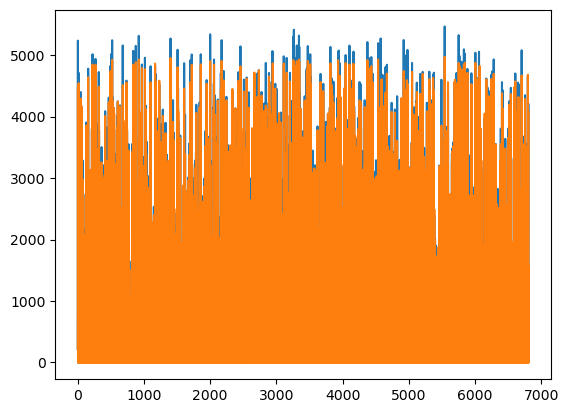

MAE A: 43.41904238968348


In [156]:
# Clip negative values
pred_A = np.clip(pred_A, 0, None)
#pred_B = np.clip(pred_B, 0, None)
#pred_C = np.clip(pred_C, 0, None)

# Evaluate 
mae_A = mean_absolute_error(y_test_A, pred_A)
#mae_B = mean_absolute_error(y_test_B, pred_B)
#mae_C = mean_absolute_error(y_test_C, pred_C)

plt.plot(y_test_A, label='True')
plt.plot(pred_A, label='Predicted')
plt.show()

print(f"MAE A: {mae_A}")
#print(f"MAE B: {mae_B}")
#print(f"MAE C: {mae_C}")

There are no negative values in the DataFrame.


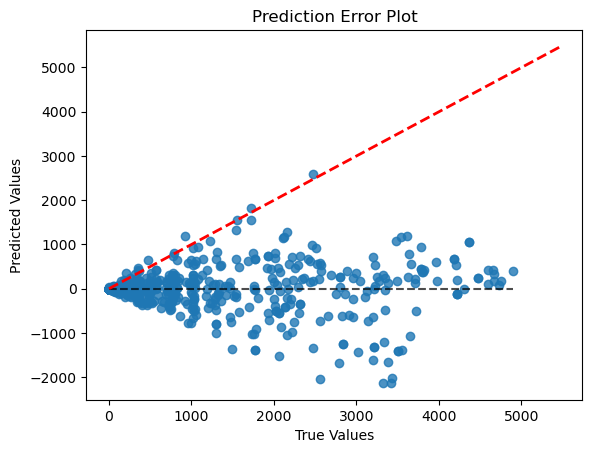

In [86]:
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(y_test_A, pred_A, ax=ax)
ax.plot([y_test_A.min(), y_test_A.max()], [y_test_A.min(), y_test_A.max()], '--r', linewidth=2)
ax.set_title('Prediction Error Plot')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.show()

 ## Last model 155
 
 pv_measurement                           27233 non-null  float64       
 1   date_forecast                            27233 non-null  datetime64[ns]
 2   snow_accumulation                        27233 non-null  float32       
 3   total_radiation                          27233 non-null  float32       
 4   sfc_pressure:hPa                         27233 non-null  float32       
 5   month                                    27233 non-null  int32         
 6   date_forecast_fft_amplitude              27233 non-null  float64       
 7   date_forecast_fft_phase                  27233 non-null  float64       
 8   sun_elevation:d_fft_amplitude            27233 non-null  float64       
 9   sun_elevation:d_fft_phase                27233 non-null  float64       
 10  clear_sky_rad:W_rate_of_change           27233 non-null  float32       
 11  direct_rad:W_rate_of_change              27233 non-null  float32       
 12  diffuse_rad:W_rate_of_change             27233 non-null  float32       
 13  total_radiation_rate_of_change           27233 non-null  float32       
 14  effective_cloud_cover:p_rate_of_change   27233 non-null  float32       
 15  total_cloud_cover:p_rate_of_change       27233 non-null  float32       
 16  observed                                 27233 non-null  int64         
 17  sun_azimuth:d_lag_7                      27233 non-null  float32       
 18  sfc_pressure:hPa_lag_8                   27233 non-null  float32       
 19  t_1000hPa:K_lag_4                        27233 non-null  float32       
 20  dew_or_rime:idx_lag_11                   27233 non-null  float32       
 21  relative_humidity_1000hPa:p_lag_-3       27233 non-null  float32       
 22  temp_dewpoint_diff_lag_-4                27233 non-null  float32       
 23  dew_point_2m:K_lag_19                    27233 non-null  float32       
 24  visibility:m_lag_-2                      27233 non-null  float32       
 25  t_1000hPa:K_rolling_avg_24               27233 non-null  float64       
 26  msl_pressure:hPa_rolling_avg_24          27233 non-null  float64       
 27  absolute_humidity_2m:gm3_rolling_avg_24  27233 non-null  float64       
 28  total_cloud_cover:p_rolling_avg_6        27233 non-null  float64       
 29  total_radiation_rolling_avg_3            27233 non-null  float64       
 30  diffuse_rad:W                            27233 non-null  float32       
 31  diffuse_rad_1h:J                         27233 non-null  float32       
 32  direct_rad:W                             27233 non-null  float32       
 33  direct_rad_1h:J                          27233 non-null  float32       
 34  clear_sky_rad:W                          27233 non-null  float32       
 35  sun_elevation:d                          27233 non-null  float32       
 36  t_1000hPa:K                              27233 non-null  float32       
 37  effective_cloud_cover:p                  27233 non-null  float32       
 38  clear_sky_energy_1h:J                    27233 non-null  float32       
 39  sun_elevation_direct_rad_interaction     27233 non-null  float32       
 40  humidity_temp_interaction                27233 non-null  float32       
 41  temp_rad_interaction                     27233 non-null  float32       
 42  total_cloud_cover:p                      27233 non-null  float32       
 43  air_density_2m:kgm3                      27233 non-null  float32       
 44  msl_pressure:hPa_lag_3                   27233 non-null  float32       
 45  t_1000hPa:K_rate_of_change               27233 non-null  float32       
 46  wind_vector_magnitude                    27233 non-null  float32       
 47  average_wind_speed                       27233 non-null  float32       
 48  visibility:m                             27233 non-null  float32       
 49  dew_point_2m:K                           27233 non-null  float32       
 50  pressure_gradient                        27233 non-null  float32       
 51  temp_dewpoint_diff                       27233 non-null  float32       
 52  sun_elevation:d_rolling_avg_6            27233 non-null  float64       
 53  relative_humidity_1000hPa:p              27233 non-null  float32       
 54  pressure_50m:hPa                         27233 non-null  float32       
 55  sun_azimuth:d                            27233 non-null  float32       
 56  absolute_humidity_2m:gm3                 27233 non-null  float32       